In [ ]:

import os
import numpy as np
#!pip install git+https://github.com/zalandoresearch/fashion-mnist/utils/mnist_reader.py

if not os.path.exists("fashion-mnist"):
  os.system("git clone https://github.com/zalandoresearch/fashion-mnist")

In [ ]:
import sys
sys.path.append('fashion-mnist/utils')

import mnist_reader

os.listdir("./fashion-mnist/data/fashion")

data_dir = 'fashion-mnist/data/fashion'

train_files= mnist_reader.load_mnist(data_dir, kind='train')

test_files= mnist_reader.load_mnist(data_dir, kind='t10k')
train_dataset_path="./fashion-mnist/data/fashion"


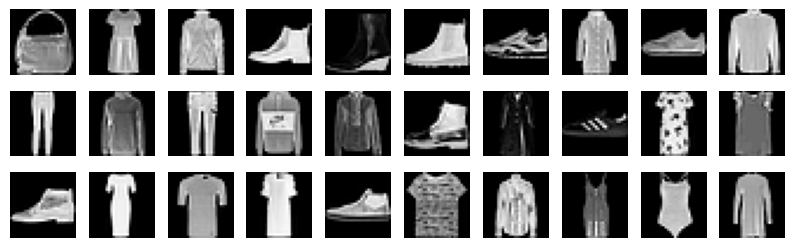

In [ ]:
images, labels =train_files
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 10, figsize=((10, 3)))
for ax, train_file in zip(axs.ravel(), np.random.choice(len(images), axs.size)):
    image = images[train_file]
    ax.imshow(image.reshape(28,28), cmap="gray")
    ax.set_axis_off()
plt.show()

In [ ]:
import torch
X_train_tensor = torch.tensor(images, dtype=torch.float32).view(-1, 1, 28, 28) / 255.0
test_tensor_images=torch.tensor(test_files[0], dtype=torch.float32)
test_tensor_labels=torch.tensor(test_files[1], dtype=torch.float32)

In [ ]:
X_train_tensor.max()

tensor(1.)

In [ ]:
!pip install deeplay
import deeplay as dl
from torch.nn import BCELoss


In [ ]:
vae = dl.VariationalAutoEncoder(
    channels=[32, 64],
    latent_dim=2,
    reconstruction_loss=BCELoss(reduction="sum"),
    beta=1,
).create()
print(vae)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
vae_trainer = dl.Trainer(max_epochs=100, accelerator="auto")
vae_trainer.fit(vae, train_loader)

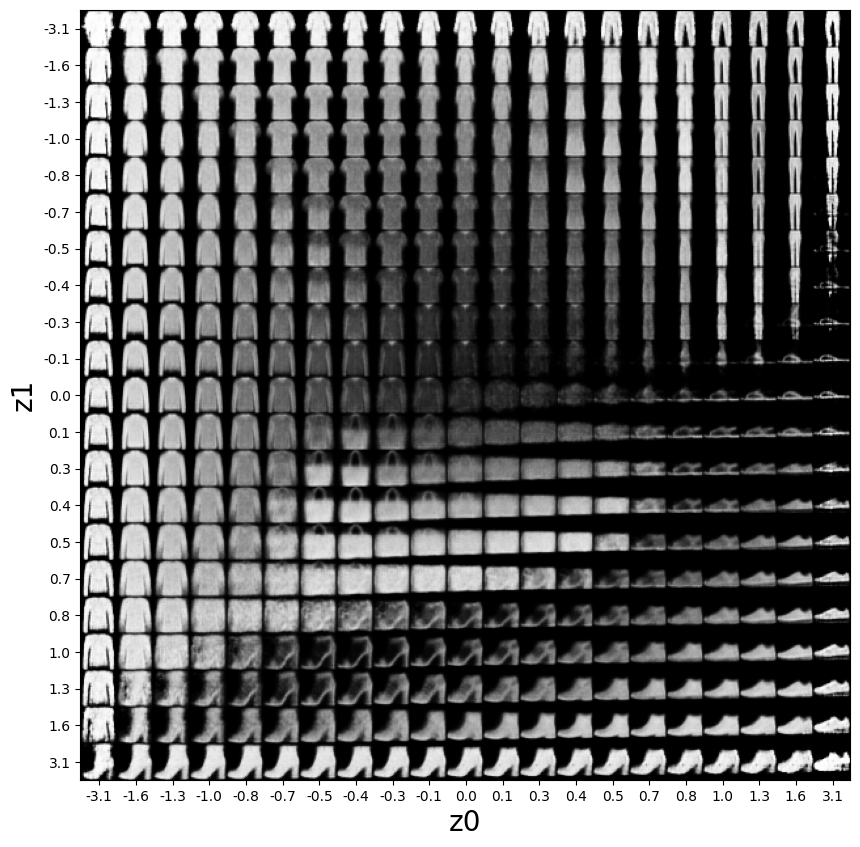

In [ ]:
from torch.distributions.normal import Normal

img_num, img_size = 21, 28

z0_grid = Normal(0, 1).icdf(torch.linspace(0.001, 0.999, img_num))
z1_grid = Normal(0, 1).icdf(torch.linspace(0.001, 0.999, img_num))

image = np.zeros((img_num * img_size, img_num * img_size))

for i0, z0 in enumerate(z0_grid):
    for i1, z1 in enumerate(z1_grid):
        z = torch.stack((z0, z1)).unsqueeze(0)
        generated_image = vae.decode(z).clone().detach()
        image[
            i1 * img_size : (i1 + 1) * img_size,
            i0 * img_size : (i0 + 1) * img_size,
        ] = generated_image.numpy().squeeze()

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")
plt.xticks(
    np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
    np.round(z0_grid.numpy(), 1),
)
plt.yticks(
    np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
    np.round(z1_grid.numpy(), 1),
)
plt.xlabel("z0", fontsize=20)
plt.ylabel("z1", fontsize=20)
plt.show()

In [ ]:
test_dataset = TensorDataset(test_tensor_images, test_tensor_labels)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
mu_list, test_labels = [], []  ### Carlo: changed z back to mu
for image, label in test_loader:
    mu, _ = vae.encode(image.view(-1,1,28,28))
    mu_list.append(mu)
    test_labels.append(label)
mu_tensor = torch.cat(mu_list, dim=0).detach().numpy()
test_labels = torch.cat(test_labels, dim=0).numpy()

In [ ]:
label_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


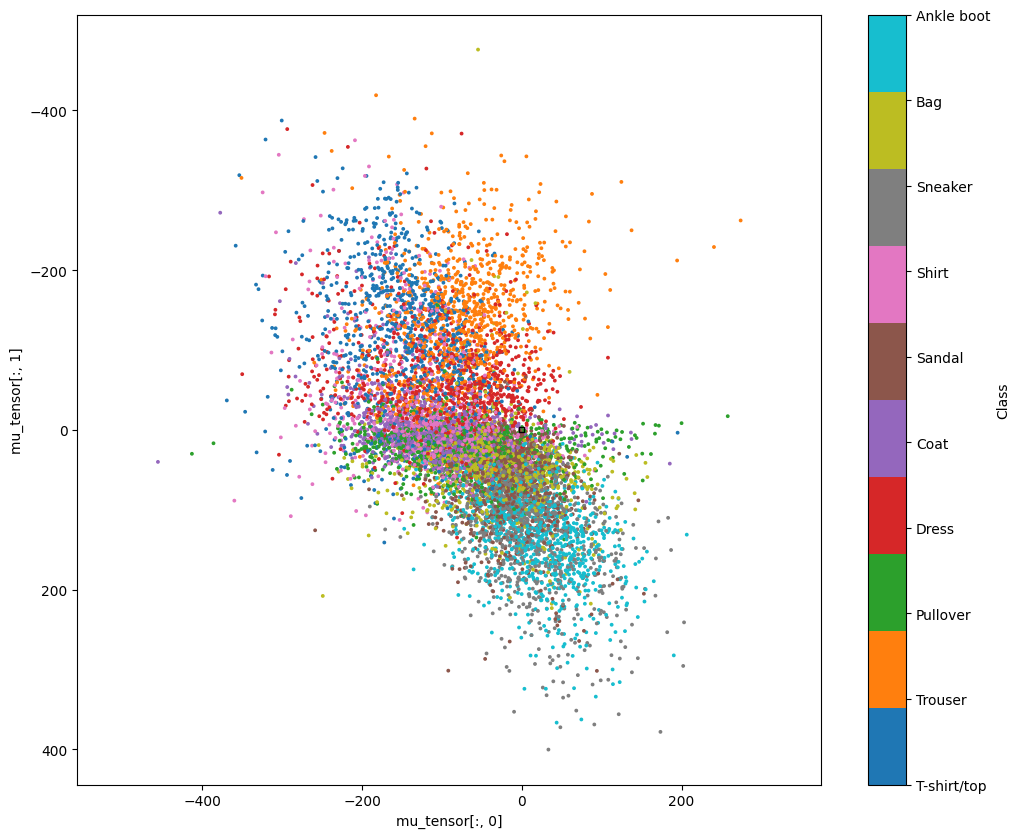

In [ ]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(12, 10))
scatter =plt.scatter(mu_tensor[:, 0], mu_tensor[:, 1], s=3, c=test_labels, cmap="tab10")
plt.xlabel("mu_tensor[:, 0]")
plt.ylabel("mu_tensor[:, 1]")

cbar = plt.colorbar(scatter, ticks=range(len(label_names)), label='Class')
cbar.set_ticklabels([label_names[i] for i in range(len(label_names))])

plt.gca().invert_yaxis()  ### Carlo: this is important to keep the same order as the plot above
plt.axis("equal")
plt.gca().add_patch(Rectangle((-3.1, -3.1), 6.2, 6.2, fc="none", ec="k", lw=1))
plt.show()